<span style="color: purple">

Load in stored variables:

</span>

In [1]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf

<span style="color: purple">

Import packages:

</span>

In [2]:
# Import necessary packages
import os
from glob import glob

import earthaccess # Access NASA data from the cloud
import pandas as pd
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

## STEP 2b: DATA ACCESS - TOPOGRAPHIC: ELEVATION

One way to access reliable elevation data is from the [SRTM
dataset](https://www.earthdata.nasa.gov/data/instruments/srtm),
available through the [earthaccess
API](https://earthaccess.readthedocs.io/en/latest/quick-start/).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download SRTM elevation data for a particular location and
calculate any additional topographic variables you need such as slope or
aspect.</p>
<p>Then, use loops to download and organize the rasters you will need to
complete this section. Include topographic parameters that will help you
to answer your scientific question.</p></div></div>

> **Warning**
>
> Be careful when computing the slope from elevation that the units of
> elevation match the projection units (e.g. meters and meters, not
> meters and degrees). You will need to project the SRTM data to
> complete this calculation correctly.

<span style="color: purple">

#### Load in Siskiyou National Forest elevation data

</span>

In [3]:
# Define data directory for the Siskiyou elevation data
siskiyou_elevation_dir = os.path.join(data_dir, 'siskiyou-elevation-srtm')

os.makedirs(siskiyou_elevation_dir, exist_ok=True)

siskiyou_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm'

In [4]:
# Log in to earthaccess
earthaccess.login()

# Search earthaccess datasets for SRTM
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
SRTMIMGM NASA Shuttle Radar Topography Mission Combined Image Data Set V003
SRTMIMGR NASA Shuttle Radar Topography Mission Swath Image Data V003
GFSAD30EUCEARUM

In [5]:
# Siskiyou data search
siskiyou_srtm_pattern = os.path.join(siskiyou_elevation_dir, '*.hgt.zip')

# Define siskiyou elevation bounds
siskiyou_elev_bounds = tuple(siskiyou_forest_gdf.total_bounds)

# Add buffer to siskiyou elevation bounds
buffer = .025
siskiyou_xmin, siskiyou_ymin, siskiyou_xmax, siskiyou_ymax = siskiyou_elev_bounds
siskiyou_elev_bounds_buffer = (siskiyou_xmin-buffer,
                               siskiyou_ymin-buffer,
                               siskiyou_xmax+buffer,
                               siskiyou_ymax+buffer)

if not glob(siskiyou_srtm_pattern):
    # Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
    siskiyou_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=siskiyou_elev_bounds_buffer
    )
    # Download SRTM files
    siskiyou_srtm_results = earthaccess.download(
        siskiyou_srtm_search,
        siskiyou_elevation_dir)
else:
    print('SRTM files already downloaded')

# Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
siskiyou_srtm_search = earthaccess.search_data(
    short_name='SRTMGL1',
    bounding_box=siskiyou_elev_bounds_buffer
)
# Download SRTM files
siskiyou_srtm_results = earthaccess.download(
    siskiyou_srtm_search,
    siskiyou_elevation_dir)

# Check siskiyou_srtm_results download
# srtm dataset files are geotiffs but they instead have a .hgt tag (height)
# results are also .zip files
siskiyou_srtm_results

SRTM files already downloaded


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N41W124.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N42W124.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N41W125.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N42W125.SRTMGL1.hgt.zip']

In [6]:
# Open Siskiyou SRTM files
siskiyou_srtm_da_list = []
for srtm_path in glob(siskiyou_srtm_pattern):
    # Open files and put them in a DataArray
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop DataArrays
    srtm_cropped_da = tile_da.rio.clip_box(*siskiyou_elev_bounds_buffer)
    siskiyou_srtm_da_list.append(srtm_cropped_da)

In [7]:
# Merge tiles
siskiyou_srtm_da = merge_arrays(siskiyou_srtm_da_list)

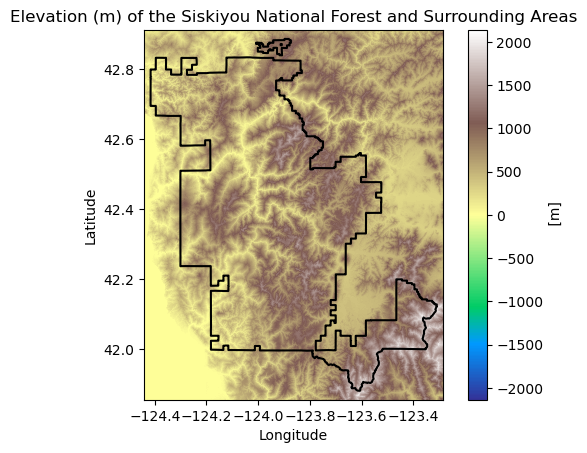

In [8]:
# Check SRTM data w/ Siskiyou plotted on top
siskiyou_srtm_da.plot(cmap='terrain')

siskiyou_forest_gdf.boundary.plot(ax = plt.gca(), color='black')
plt.title('Elevation (m) of the Siskiyou National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

<span style="color: purple">

#### Load in Los Padres National Forest elevation data

</span>

In [9]:
# Define data directory for the Los Padres elevation data
padres_elevation_dir = os.path.join(data_dir, 'padres-elevation-srtm')

os.makedirs(padres_elevation_dir, exist_ok=True)

padres_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm'

In [10]:
# Los Padres data search
padres_srtm_pattern = os.path.join(padres_elevation_dir, '*.hgt.zip')

# Define padres elevation bounds
padres_elev_bounds = tuple(padres_forest_gdf.total_bounds)

# Add .025 buffer to bounds
c_xmin, c_ymin, c_xmax, c_ymax = padres_elev_bounds
padres_elev_bounds_buffer = (c_xmin-buffer,
                            c_ymin-buffer,
                            c_xmax+buffer,
                            c_ymax+buffer)

if not glob(padres_srtm_pattern):
    padres_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=padres_elev_bounds_buffer
    )
    # Download SRTM files
    padres_srtm_results = earthaccess.download(padres_srtm_search,
                                              padres_elevation_dir)
else:
    print('SRTM files already downloaded.')

# Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
padres_srtm_search = earthaccess.search_data(
    short_name='SRTMGL1',
    bounding_box=padres_elev_bounds_buffer
)
# Download SRTM files
padres_srtm_results = earthaccess.download(padres_srtm_search,
                                            padres_elevation_dir)

# Check padres_srtm_results download
padres_srtm_results

SRTM files already downloaded.


QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N35W122.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N36W122.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N36W120.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N35W120.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N34W120.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N34W121.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N35W119.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N36W121.SRTMGL1.hgt.zip',


In [11]:
# Open Los Padres SRTM files
padres_srtm_da_list = []
for srtm_path in glob(padres_srtm_pattern):
    # Open files and put them in a DataArray
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop DataArrays
    srtm_cropped_da = tile_da.rio.clip_box(*padres_elev_bounds_buffer)
    padres_srtm_da_list.append(srtm_cropped_da)
padres_srtm_da_list

[<xarray.DataArray (y: 2281, x: 1017)> Size: 9MB
 [2319777 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 8kB -119.0 -119.0 -119.0 ... -118.7 -118.7 -118.7
   * y            (y) float64 18kB 35.0 35.0 35.0 35.0 ... 34.37 34.37 34.37
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     units:          m,
 <xarray.DataArray (y: 2281, x: 3601)> Size: 33MB
 [8213881 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 29kB -120.0 -120.0 -120.0 ... -119.0 -119.0 -119.0
   * y            (y) float64 18kB 35.0 35.0 35.0 35.0 ... 34.37 34.37 34.37
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     units:          m,
 <xarray.DataArray (y: 2281, x: 3601)> Size: 33MB
 [8213881 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 29kB -121.0 -121.0 -121.0 ... -120.0 -120.0 -120.0
   * y            (y) float64

In [12]:
# Merge tiles
padres_srtm_da = merge_arrays(padres_srtm_da_list)

MemoryError: Unable to allocate 1.26 GiB for an array with shape (7428, 11365, 2) and data type float64

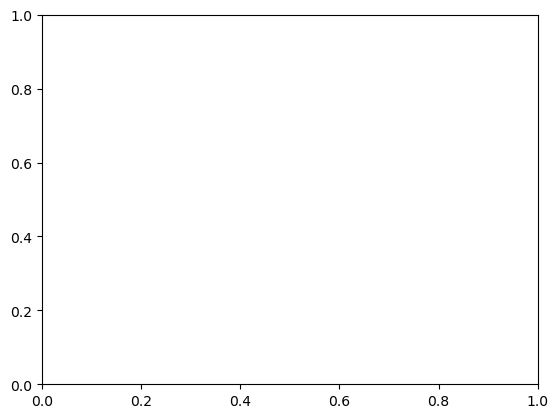

In [14]:
# Check SRTM data w/ padres plotted on top
padres_srtm_da.plot(cmap='terrain')

padres_forest_gdf.boundary.plot(ax = plt.gca(), color='black')
plt.title('Elevation (m) of the Los Padres National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()